In [1]:
using NeuralVerification, LazySets, Test, LinearAlgebra, GLPKMathProgInterface
import NeuralVerification: ReLU, Id
using PyPlot

In [14]:
blue21005x50_file = "$(@__DIR__)models/network_blue2-100_5x50_fc4.nnet"
blue_network = read_nnet(blue21005x50_file, last_layer_activation = ReLU())

Network(NeuralVerification.Layer[Layer{ReLU,Float64}([-0.0368166 -0.0706536 … -0.0912468 -0.0490859; 0.189174 0.00236389 … 0.00713663 0.182075; … ; 0.0795645 0.0408027 … -0.034356 0.124015; -0.0722785 0.0640254 … -0.102303 0.0795488], [0.138137, 0.080275, 0.121374, 0.158729, 0.10748, 0.193207, 0.162001, 0.096951, 0.151076, 0.107592  …  0.10856, 0.16757, 0.151847, 0.161865, 0.125018, 0.162935, 0.091105, 0.148989, 0.108876, 0.157476], ReLU()), Layer{ReLU,Float64}([-0.0758726 -0.204673 … 0.125558 0.0827474; -0.0933417 0.366084 … 0.137936 0.0764537; … ; 0.0242026 0.0288707 … -0.116681 -0.172489; 0.0648067 0.280223 … 0.157698 0.0285247], [0.114185, 0.175259, 0.170901, 0.146288, 0.115158, 0.0981914, 0.132048, 0.125148, 0.154286, 0.0661286  …  0.13286, 0.132969, 0.134941, 0.0976865, 0.120363, 0.11931, 0.138777, 0.107775, 0.104577, 0.167133], ReLU()), Layer{ReLU,Float64}([0.0118436 0.109166 … -0.0584732 0.124637; -0.288968 0.0503578 … 0.157053 -0.0628537; … ; 0.0690715 0.0761014 … 0.124035 0.0

In [15]:
[size(layer.bias) for layer in blue_network.layers]

5-element Array{Tuple{Int64},1}:
 (50,)
 (50,)
 (50,)
 (50,)
 (50,)

In [16]:
cav = [-0.0149315 , -0.04210887, -0.21179856, -0.09526453, -0.06350145,
         -0.13195272,  0.04009417, -0.07852261, -0.0618356 , -0.33904928,
         -0.01614001, -0.05799621,  0.08888276, -0.24976716, -0.26743488,
          0.00440992,  0.09774179, -0.25361664,  0.24287269, -0.00058376,
         -0.02460891, -0.        , -0.2622163 , -0.25330892, -0.11236939,
         -0.20838313, -0.06140403, -0.15776368, -0.09362213, -0.21058005,
         -0.18359654, -0.14748262, -0.0937468 ,  0.02737032,  0.06902506,
         -0.16348283, -0.17014746, -0.14261157, -0.        , -0.        ,
         -0.25158604,  0.22968987, -0.11010671, -0.17172886, -0.23623435,
         -0.10722136, -0.11911813, -0.        , -0.14326727, -0.19573819];

In [17]:
redChannelIndices = [x for x in 1:28*28*3 if x % 3 == 1]
greenChannelIndices = [x for x in 1:28*28*3 if x % 3 == 2]
blueChannelIndices = [x for x in 1:28*28*3 if x % 3 == 0];

In [18]:
lower = zeros(2352)
upper = zeros(2352)

lower[redChannelIndices] .= 0.0
upper[redChannelIndices] .= 25.0


lower[greenChannelIndices] .= 0.0
upper[greenChannelIndices] .= 25.0

lower[blueChannelIndices] .= 150.0
upper[blueChannelIndices] .= 200.0;

# Input Set

In [19]:
X = Hyperrectangle(low=lower, high=upper)

Hyperrectangle{Float64}([12.5, 12.5, 175.0, 12.5, 12.5, 175.0, 12.5, 12.5, 175.0, 12.5  …  175.0, 12.5, 12.5, 175.0, 12.5, 12.5, 175.0, 12.5, 12.5, 175.0], [12.5, 12.5, 25.0, 12.5, 12.5, 25.0, 12.5, 12.5, 25.0, 12.5  …  25.0, 12.5, 12.5, 25.0, 12.5, 12.5, 25.0, 12.5, 12.5, 25.0])

# Output Set

In [20]:
b = [0.0]
 
Yc = HPolytope(cav', b)
Y = complement(Yc)

PolytopeComplement of:
  HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([-0.0149315, -0.0421089, -0.211799, -0.0952645, -0.0635015, -0.131953, 0.0400942, -0.0785226, -0.0618356, -0.339049  …  -0.251586, 0.22969, -0.110107, -0.171729, -0.236234, -0.107221, -0.119118, -0.0, -0.143267, -0.195738], 0.0)])


# Problem Definition

In [21]:
problem_av2 = Problem(blue_network, X, Y);

In [ ]:
#solver = NSVerify(m=100)
#println("NSVerify")
#solver = ReluVal()
solver = MIPVerify()
timed_result = @timed solve(solver, problem_av2)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])
println("")

counter_example = timed_result[1].counter_example;

# Sanity Check

In [23]:
Yc = HPolytope(-cav', b)
Y = complement(Yc)
solver = MIPVerify()
problem_av2_sanity = Problem(blue_network, X, Y);
timed_result = @timed solve(solver, problem_av2_sanity)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])
println("")

counter_example = timed_result[1].counter_example;

 - Time: 16.878630195 s - Output: CounterExampleResult(:holds, Float64[])


# other approach

In [133]:
out_poly = HPolytope(-tcav', b)
problem_av2_poly = Problem(blue_network, X, out_poly);

In [136]:
#solver = NSVerify(m=100)
#println("NSVerify")

solver = ReluVal(max_iter=1000)
timed_result = @timed solve(solver, problem_av2_poly)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])
println("")

counter_example = timed_result[1].counter_example;

 - Time: 206.786838196 s - Output: BasicResult(:unknown)


ErrorException: type BasicResult has no field counter_example

In [129]:
red_chan = counter_example[redChannelIndices]
blue_chan = counter_example[redChannelIndices]
green_chan = counter_example[redChannelIndices]

view_counter = zeros(28,28,3)

view_counter[:,:,1] = reshape(red_chan, 28, 28)./255.0
view_counter[:,:,2] = reshape(blue_chan, 28, 28)./255.0
view_counter[:,:,3] = reshape(green_chan, 28, 28)./255.0

28×28 Array{Float64,2}:
 0.0490196  0.0490196  0.0490196  …  0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196  …  0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196  …  0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 0.0490196  0.0490196  0.0490196     0.0490196  0.0490196  0.0490196
 ⋮                                ⋱  ⋮                              
 0.0490196

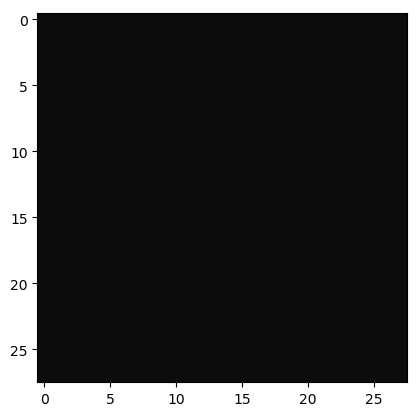

PyObject <matplotlib.image.AxesImage object at 0x14ddba470>

In [130]:
imshow(view_counter)